In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.mixed_method_0.mixed_method_0_operators import charge_density_two_stream_mixed_method_0
from operators.legendre.legendre_operators import xi_legendre
from operators.aw_hermite.aw_hermite_operators import aw_psi_hermite, aw_psi_hermite_complement
from operators.mixed_method_0.setup_mixed_method_0_two_stream import SimulationSetupMixedMethod0
from operators.adaptive_aw_hermite import updated_u, updated_alpha
from operators.poisson_solver import gmres_solver
from operators.aw_hermite.aw_hermite_operators import total_mass_aw_hermite, total_momentum_aw_hermite, total_energy_k_aw_hermite
from operators.legendre.legendre_operators import total_mass_legendre, total_momentum_legendre, total_energy_k_legendre

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Enable LaTeX rendering
matplotlib.rcParams['text.usetex'] = True

# Mixed method #0 bump on tail (with $u(t)$ and $\alpha(t)$)

In [35]:
setup = SimulationSetupMixedMethod0(Nx=51,
                                    Nv_e1=100,
                                    Nv_e2=150,
                                    epsilon=1e-2,
                                    v_a=-8.5,
                                    v_b=8.5,
                                    alpha_e1=np.sqrt(2),
                                    u_e1=0,
                                    u_e2=4.5,
                                    alpha_e2=1/np.sqrt(2),
                                    L=20 * np.pi / 3,
                                    dt=1e-2,
                                    T0=0,
                                    T=40,
                                    k0=1,
                                    nu_L=1,
                                    nu_H=4,
                                    gamma=0.5,
                                    u_tol=1e-1,
                                    alpha_tol=1e-1,
                                    n0_e1=0.9,
                                    n0_e2=0.1)

In [36]:
# ions (unperturbed)
C0_ions = np.ones(setup.Nx)

In [37]:
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx+1)
v_ = np.linspace(setup.v_a, setup.v_b, 1000, endpoint=True)

# simulation results

In [38]:
skip = 1
# load the simulation results
# save results
sol_midpoint_u = np.load("../../data/mixed_method_0_aw_hermite_legendre/bump_on_tail/sol_u_NvH_" + str(setup.Nv_e1) 
                         + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../../data/mixed_method_0_aw_hermite_legendre/bump_on_tail/sol_t_NvH_" + str(setup.Nv_e1) 
                         + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

dt = 0.01 * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(12750, 4001)
(4001,)


In [39]:
runtime = np.load("../../data/mixed_method_0_aw_hermite_legendre/bump_on_tail/sol_runtime_NvH_" + str(setup.Nv_e1) + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
runtime

array([4902.058952  , 1235.42217112])

In [40]:
alpha_e1=np.load("../../data/mixed_method_0_aw_hermite_legendre/bump_on_tail/alpha_e1_Nve1_" + str(setup.Nv_e1)
            + "_Nve2_" + str(setup.Nv_e2) + "_Nx_" + str(setup.Nx)
            + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

u_e1=np.load("../../data/mixed_method_0_aw_hermite_legendre/bump_on_tail/u_e1_Nve1_" + str(setup.Nv_e1)
            + "_Nve2_" + str(setup.Nv_e2) + "_Nx_" + str(setup.Nx)
            + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

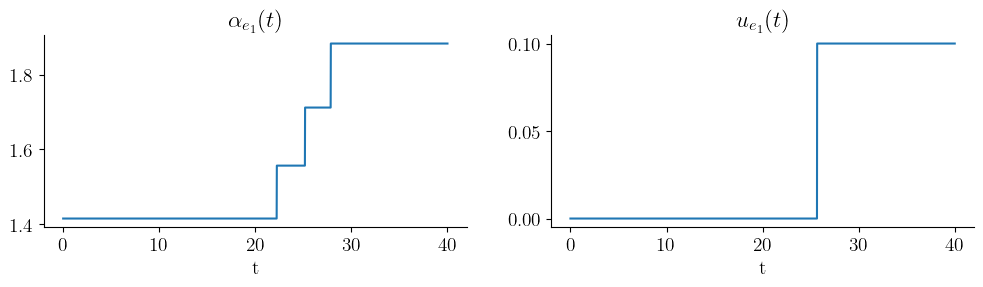

In [41]:
fig, ax  = plt.subplots(ncols=2, figsize=(12, 2.5))
ax[0].plot(sol_midpoint_t, alpha_e1)
ax[1].plot(sol_midpoint_t, u_e1)

ax[1].set_xlabel("t")
ax[0].set_xlabel("t")
ax[1].set_title(r"$u_{e_{1}}(t)$")
ax[0].set_title(r"$\alpha_{e_{1}}(t)$")

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

In [42]:
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

In [43]:
# initialize the states for implicit midpoint (symplectic)
state_e_H = np.zeros((setup.Nv_e1,  setup.Nx + 1, len(sol_midpoint_t)))
state_e_L = np.zeros((setup.Nv_e2,  setup.Nx + 1, len(sol_midpoint_t)))

for ii in np.arange(0, len(sol_midpoint_t)):
    # immobile ions
    state_e_H[:, :-1, ii]  = np.reshape(sol_midpoint_u[:setup.Nv_e1*setup.Nx, ii], (setup.Nv_e1, setup.Nx)) 
    state_e_H[:, -1, ii] = state_e_H[:, 0, ii]
    # electrons species 2
    state_e_L[:, :-1, ii]  = np.reshape(sol_midpoint_u[setup.Nv_e1*setup.Nx:, ii], (setup.Nv_e2, setup.Nx))  
    state_e_L[:, -1, ii] = state_e_L[:, 0, ii]

    # solve Poisson's equation to obtain an electric field
    rho = charge_density_two_stream_mixed_method_0(q_e=setup.q_e, v_a=setup.v_a, v_b=setup.v_b, 
                                                   alpha_e=alpha_e1[ii],
                         C0_e_hermite=state_e_H[0, :setup.Nx, ii], 
                         C0_e_legendre=state_e_L[0, :setup.Nx, ii])

    E_midpoint[:-1, ii] = gmres_solver(rhs=rho, D=setup.D, D_inv=setup.D_inv, a_tol=1e-12, r_tol=1e-12)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

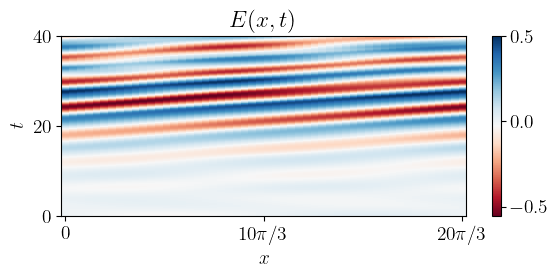

In [44]:
# plot the electric field
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.pcolormesh(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu")
cbar = fig.colorbar(pos)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, 10*np.pi/3, 20*np.pi/3-.05])
_ = ax.set_xticklabels([r"0", r"$10\pi/3$", r"$20\pi/3$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

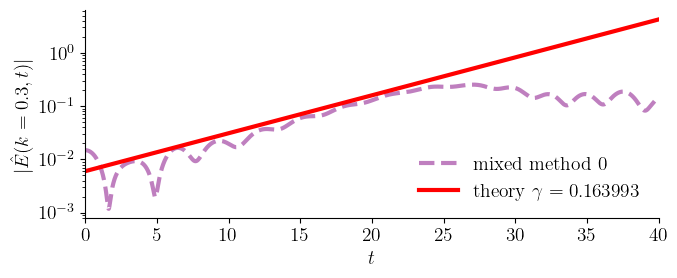

In [45]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, np.abs(np.fft.fft(E_midpoint, axis=0, norm="forward")[1, :]), "--", c="purple", alpha=0.5, linewidth=3, label=r"mixed method 0") 
ax.plot(sol_midpoint_t, 6e-3*np.exp(0.163993367317754*sol_midpoint_t), linewidth=3, color="red", label=r"theory $\gamma = 0.163993$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(k=0.3, t)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
#ax.set_ylim(1e-5, 1e-2)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=14, loc='lower right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../../figures/mixed_method_0/bump_on_tail/bump_on_tail_growth_rate_legendre.png", dpi=300)

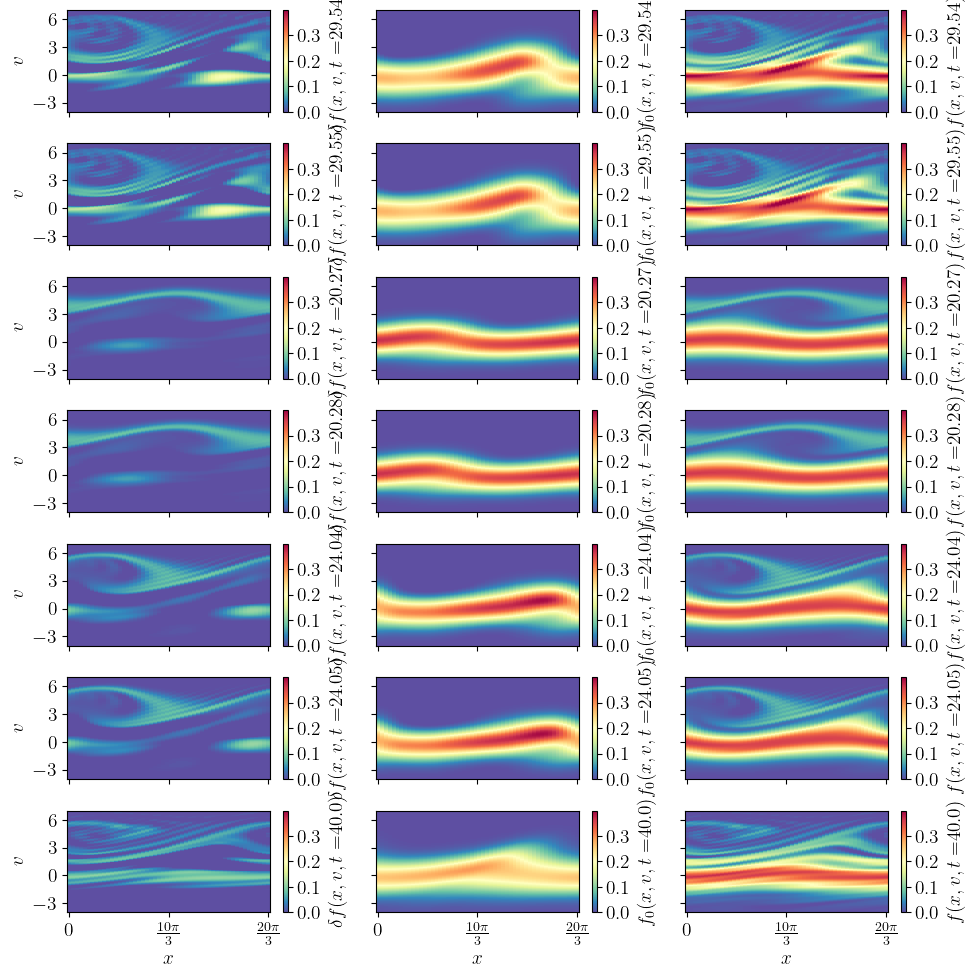

In [46]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=7, ncols=3, figsize=(10, 10), sharex=True, sharey=True)

levels = np.linspace(-0.05, 0.4, 50)

for tt, ii in enumerate([int(29.54/setup.dt), int(29.55/setup.dt), int(20.27/setup.dt), int(20.29/setup.dt),
                         int(24.04/setup.dt), int(24.05/setup.dt), -1]):
    ii = int(ii)
    distribution1 = np.zeros((len(x), len(v_)))
    distribution2 = np.zeros((len(x), len(v_)))
    for jj in range(setup.Nv_e1):
        distribution1 += np.outer(state_e_H[jj, :, ii], aw_psi_hermite(v=v_, u_s=u_e1[ii], alpha_s=alpha_e1[ii], n=jj))
    for jj in range(setup.Nv_e2):
        distribution2 += np.outer(state_e_L[jj, :, ii], xi_legendre(v=v_, v_b=setup.v_b, v_a=setup.v_a, n=jj))
    pos2 = ax[tt, 0].pcolormesh(x, v_, distribution2.T, cmap="Spectral_r", vmin=0, vmax=0.4)
    pos1 = ax[tt, 1].pcolormesh(x, v_, distribution1.T, cmap="Spectral_r", vmin=0, vmax=0.4)
    pos3 = ax[tt, 2].pcolormesh(x, v_, distribution1.T + distribution2.T, cmap="Spectral_r", vmin=0, vmax=0.4)
    ax[tt, 0].set_yticks([-3, 0, 3, 6])
    ax[tt, 0].set_ylim(-4, 7)
    ax[tt, 0].set_ylabel("$v$")
    cbar = fig.colorbar(pos1)
    cbar.ax.set_ylabel('$f_{0}(x, v, t=$' + str(round(sol_midpoint_t[ii], 2)) + ")", rotation=90)
    cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])

    cbar = fig.colorbar(pos2)
    cbar.ax.set_ylabel('$\delta f(x, v, t=$' + str(round(sol_midpoint_t[ii], 2)) + ")", rotation=90)
    cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])

    cbar = fig.colorbar(pos3)
    cbar.ax.set_ylabel('$f(x, v, t=$' + str(round(sol_midpoint_t[ii], 2)) + ")", rotation=90)
    cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])

ax[tt, 0].set_xlabel("$x$")
ax[tt, 0].set_xticks([0, 10*np.pi/3, 20*np.pi/3])
ax[tt, 0].set_xticklabels([r"0", r"$\frac{10\pi}{3}$", r"$\frac{20\pi}{3}$"])

ax[tt, 1].set_xlabel("$x$")
ax[tt, 1].set_xticks([0, 10*np.pi/3, 20*np.pi/3])
ax[tt, 1].set_xticklabels([r"0", r"$\frac{10\pi}{3}$", r"$\frac{20\pi}{3}$"])
ax[tt, 2].set_xlabel("$x$")
plt.tight_layout()
plt.savefig("../../figures/mixed_method_0/bump_on_tail/bump_on_tail_evolution_mixed_method_0_Hermite_Legendre_adapt.png", dpi=600)

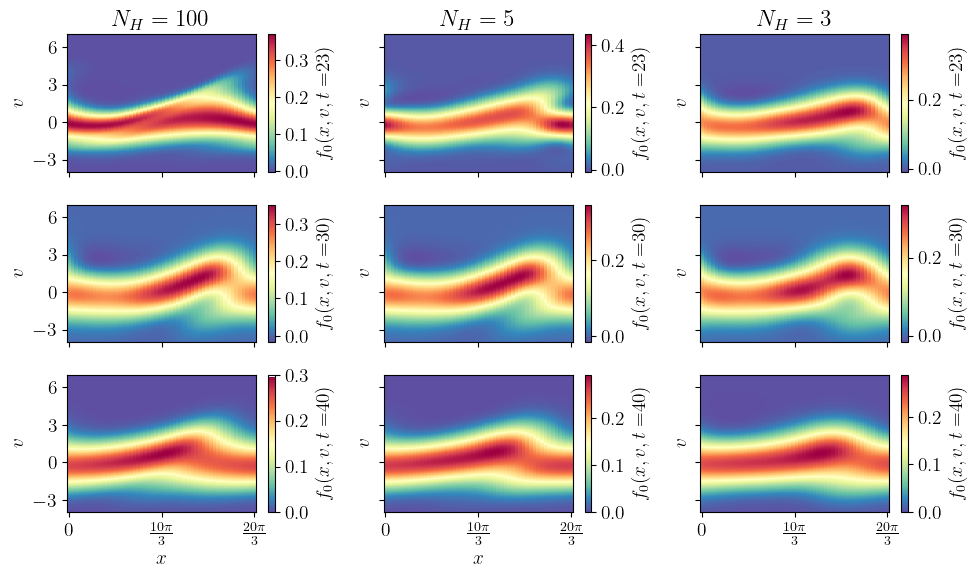

In [17]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 6), sharex=True, sharey=True)

levels = np.linspace(-0.05, 0.4, 50)

for tt, ii in enumerate([int(23.87/setup.dt), int(3*len(sol_midpoint_t)//4), -1]):
    ii = int(ii)
    distribution1 = np.zeros((len(x), len(v_)))
    for jj in range(setup.Nv_e1):
        distribution1 += np.outer(state_e_H[jj, :, ii], aw_psi_hermite(v=v_, u_s=u_e1[ii], alpha_s=alpha_e1[ii], n=jj))
    pos1 = ax[tt, 0].pcolormesh(x, v_, distribution1.T, cmap="Spectral_r")
    ax[tt, 0].set_yticks([-3, 0, 3, 6])
    ax[tt, 0].set_ylim(-4, 7)
    ax[tt, 0].set_ylabel("$v$")
    cbar = fig.colorbar(pos1)
    cbar.ax.set_ylabel('$f_{0}(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
    cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])

    distribution1 = np.zeros((len(x), len(v_)))
    for jj in range(5):
        distribution1 += np.outer(state_e_H[jj, :, ii], aw_psi_hermite(v=v_, u_s=u_e1[ii], alpha_s=alpha_e1[ii], n=jj))
    pos1 = ax[tt, 1].pcolormesh(x, v_, distribution1.T, cmap="Spectral_r")
    ax[tt, 1].set_yticks([-3, 0, 3, 6])
    ax[tt, 1].set_ylim(-4, 7)
    ax[tt, 1].set_ylabel("$v$")
    cbar = fig.colorbar(pos1)
    cbar.ax.set_ylabel('$f_{0}(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
    #cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])

    distribution1 = np.zeros((len(x), len(v_)))
    for jj in range(3):
        distribution1 += np.outer(state_e_H[jj, :, ii], aw_psi_hermite(v=v_, u_s=u_e1[ii], alpha_s=alpha_e1[ii], n=jj))
    pos1 = ax[tt, 2].pcolormesh(x, v_, distribution1.T, cmap="Spectral_r")
    ax[tt, 2].set_yticks([-3, 0, 3, 6])
    ax[tt, 2].set_ylim(-4, 7)
    ax[tt, 2].set_ylabel("$v$")
    cbar = fig.colorbar(pos1)
    cbar.ax.set_ylabel('$f_{0}(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
    #cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])

    

ax[0, 0].set_title("$N_{H}=100$")
ax[0, 1].set_title("$N_{H}=5$")
ax[0, 2].set_title("$N_{H}=3$")

ax[tt, 0].set_xlabel("$x$")
ax[tt, 0].set_xticks([0, 10*np.pi/3, 20*np.pi/3])
ax[tt, 0].set_xticklabels([r"0", r"$\frac{10\pi}{3}$", r"$\frac{20\pi}{3}$"])

ax[tt, 1].set_xlabel("$x$")
ax[tt, 1].set_xticks([0, 10*np.pi/3, 20*np.pi/3])
ax[tt, 1].set_xticklabels([r"0", r"$\frac{10\pi}{3}$", r"$\frac{20\pi}{3}$"])

plt.tight_layout()

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_31192/1929306973.py:2: RuntimeWarning: divide by zero encountered in log10
  ax[0].pcolormesh(np.arange(0, setup.Nv_e1), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_H, axis=1)[:, 1, :])).T, vmin=-5, vmax=1)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_31192/1929306973.py:3: RuntimeWarning: divide by zero encountered in log10
  ax[1].pcolormesh(np.arange(0, setup.Nv_e2), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_L, axis=1)[:, 1, :])).T, vmin=-5, vmax=1)


Text(0.5, 1.0, '$B$')

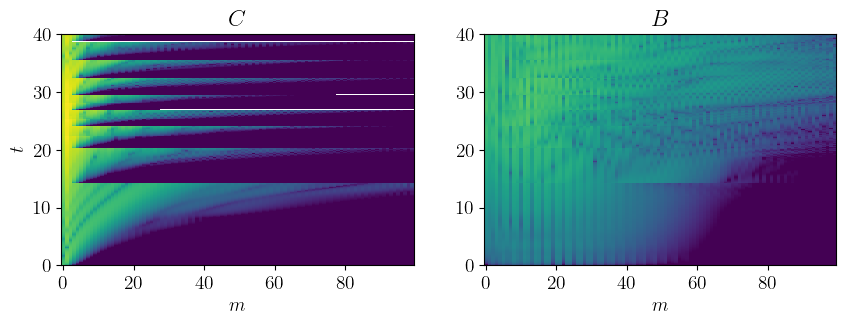

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
ax[0].pcolormesh(np.arange(0, setup.Nv_e1), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_H, axis=1)[:, 1, :])).T, vmin=-5, vmax=1)
ax[1].pcolormesh(np.arange(0, setup.Nv_e2), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_L, axis=1)[:, 1, :])).T, vmin=-5, vmax=1)
ax[0].set_xlabel("$n$")
ax[0].set_xlabel("$m$")
ax[1
    
    ].set_xlabel("$m$")
ax[0].set_ylabel("$t$")
ax[0].set_ylabel("$t$")
ax[0].set_title("$C$")
ax[1].set_title("$B$")

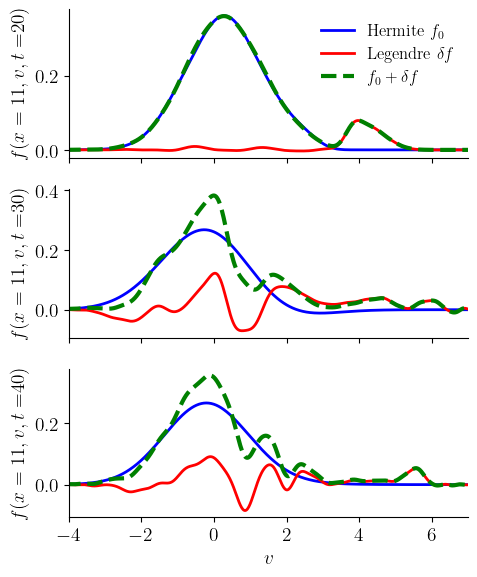

In [19]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 6), sharex=True)
for tt, ii in enumerate([2000, int(3*len(sol_midpoint_t)//4), -1]):
    ii = int(ii)
    distribution_H = np.zeros((len(x), len(v_)))
    distribution_L = np.zeros((len(x), len(v_)))
    for jj in range(setup.Nv_e1):
        distribution_H += np.outer(state_e_H[jj, :, ii], aw_psi_hermite(v=v_, u_s=u_e1[ii], alpha_s=alpha_e1[ii], n=jj))
    for jj in range(setup.Nv_e2):
        distribution_L += np.outer(state_e_L[jj, :, ii], xi_legendre(v=v_, v_b=setup.v_b, v_a=setup.v_a, n=jj))
        
    _ = ax[tt].plot(v_, distribution_H[5, :], color="blue", label="Hermite $f_{0}$", linewidth=2)
    _ = ax[tt].plot(v_, distribution_L[5, :], color="red", label="Legendre $\delta f$", linewidth=2)
    _ = ax[tt].plot(v_, distribution_L[5, :] + distribution_H[5, :], color="green", ls="--", label=r"$f_{0} + \delta f$", linewidth=3)
    ax[tt].spines['right'].set_visible(False)
    ax[tt].spines['top'].set_visible(False)
    ax[tt].set_xlim(-4, 7)
    ax[tt].set_ylabel("$f(x=11, v, t=$" + str(int(sol_midpoint_t[ii])) + ")")
legend = ax[0].legend(ncols=1, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
ax[-1].set_xlabel("$v$")
plt.tight_layout()
plt.savefig("../../figures/mixed_method_0/bump_on_tail/bump_on_tail_slice_mixed_method_0_Hermite_Legendre_adapt.png", dpi=600)

# conservation laws: mass, momentum, and energy

### mass conservation

In [20]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass_aw_hermite(state=state_e_H[:, :-1, ii], alpha_s=alpha_e1[ii], dx=setup.dx)\
                        +total_mass_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx)

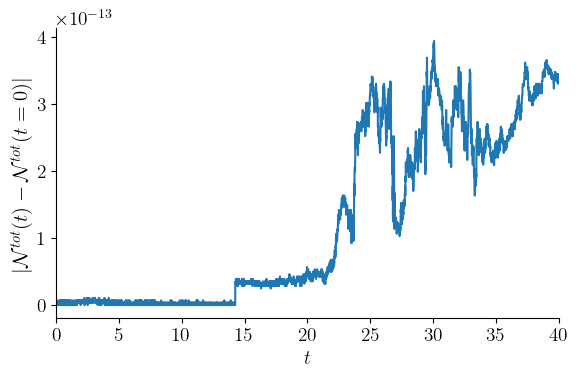

In [21]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
plt.tight_layout()

### momentum conservation

In [22]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum_aw_hermite(state=state_e_H[:, :-1, ii], alpha_s=alpha_e1[ii], u_s=u_e1[ii],
                                                   dx=setup.dx, m_s=setup.m_e)\
                            +total_momentum_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)

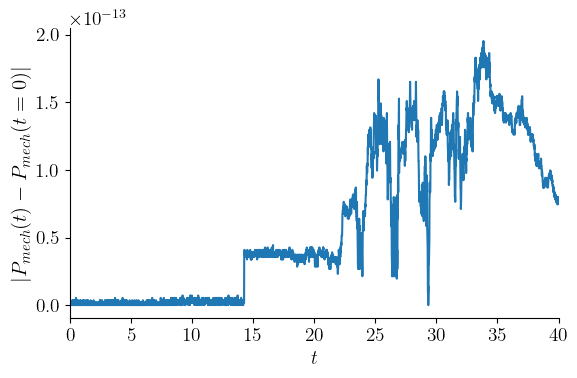

In [23]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlim(setup.T0, setup.T)
ax.set_xlabel("$t$")
plt.tight_layout()

### energy conservation

In [24]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k_aw_hermite(state=state_e_H[:, :-1, ii], alpha_s=alpha_e1[ii], u_s=u_e1[ii], dx=setup.dx, m_s=setup.m_e)\
                           +total_energy_k_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

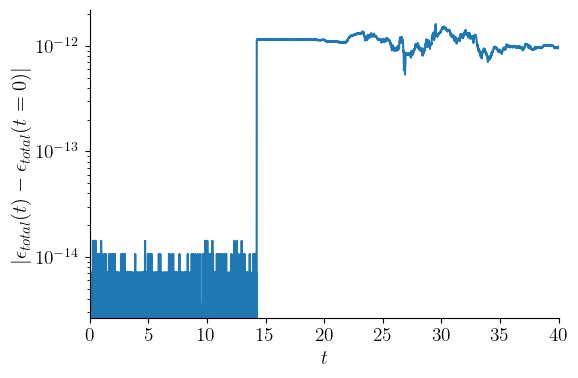

In [25]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

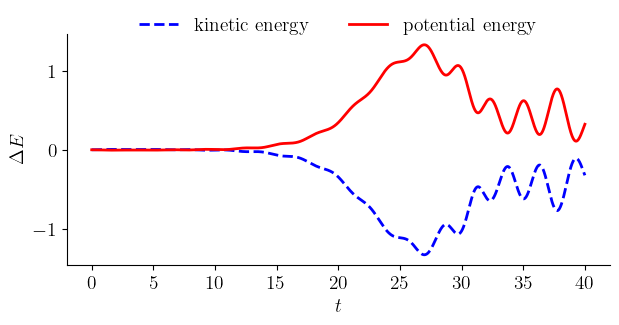

In [26]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy", ls="--", linewidth=2, color="blue")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy", linewidth=2, color="red")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("$t$")
_ = ax.set_ylabel(r"$\Delta E$")

### conservation summary

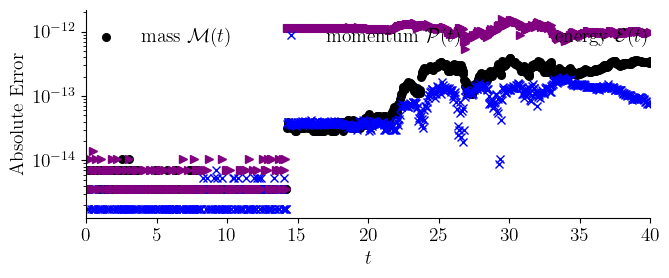

In [27]:
# plot the analytic and numerical conservation properties
skip = 5

fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::skip], np.abs(mass_midpoint-mass_midpoint[0])[::skip], s=30, color="black", label=r"mass $\mathcal{M}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(momentum_midpoint-momentum_midpoint[0])[::skip], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::skip], ">", color="purple", label=r"energy $\mathcal{E}(t)$")

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
legend = ax.legend(ncols=3, fontsize=14, loc='upper center')
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.tight_layout()